# Funnel distribution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path_toy = os.path.join(cwd, '..', 'tools', 'toy_examples_utils')
#api_path_sir = os.path.join(cwd, '..', 'tools', 'sir_ais_sampling')
models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
#models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'wasserstein')
sys.path.append(api_path_toy)
#sys.path.append(api_path_sir)
sys.path.append(os.path.join(cwd, '..', 'tools', 'sampling_utils'))

In [3]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
import importlib
from tqdm import tqdm

import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from toy_examples_utils import (prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           #xtry_langevin_sampling_plot_2d,
                           epoch_visualization,
                           plot_chain_metrics)
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          #xtry_langevin_sampling,
                          tempered_transitions_sampling,
                          gan_energy)

from adaptive_mc import adaptive_sir_correlated_dynamics, ex2_mcmc_mala
from adaptive_sir_loss import *

from flows import RNVP


from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal, 
                           Funnel,
                          Banana, Cauchy)

from params_25gaussians import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)

from general_utils import DotDict

from metrics import Evolution

In [4]:
from pathlib import Path
figpath = Path('../figs')

In [82]:
target_args = DotDict()
n_dim = 50
target_args.device = device
target_args.dim = n_dim
target_args.Q =.2
true_target = Banana(target_args).log_prob


loc_proposal = 2.+torch.zeros(n_dim).to(device)
scale_proposal = 3*torch.ones(n_dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

In [83]:
true_target_energy = lambda z: - true_target(z)


In [84]:
def plot_hist(samples, title = 'Histogram', bins=200, 
              gamma=0.5, ax_lims = [(-2,9), (-2,4)],
              save_path = 'pics/histogram_test.pdf', density = True):
    plt.close()
    plt.figure(figsize=(5, 5), dpi=300)
    plt.hist2d(samples[:,0], samples[:,1],bins=bins, density=density, range=[ax_lims[0], ax_lims[1]],norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.axis('off')
    plt.xlim((ax_lims[0][0], ax_lims[0][1]))
    plt.ylim((ax_lims[1][0], ax_lims[1][1]))
    plt.savefig(save_path, bbox_inches='tight')
    plt.show() 

In [85]:
### True target

In [86]:
from pyro.infer import MCMC, NUTS, HMC

def energy(z):
    z = z['points']
    return true_target_energy(z).sum()


#kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
kernel_true = NUTS(potential_fn=energy, full_mass = False)
init_samples = proposal.sample((1,))

init_params = {'points': init_samples}
mcmc_true = MCMC(kernel=kernel_true, num_samples = 1000, initial_params=init_params)
mcmc_true.run()

q_true = mcmc_true.get_samples(group_by_chain=True)["points"].squeeze()

Sample: 100%|██████████| 2000/2000 [02:24, 13.88it/s, step size=7.38e-02, acc. prob=0.865]


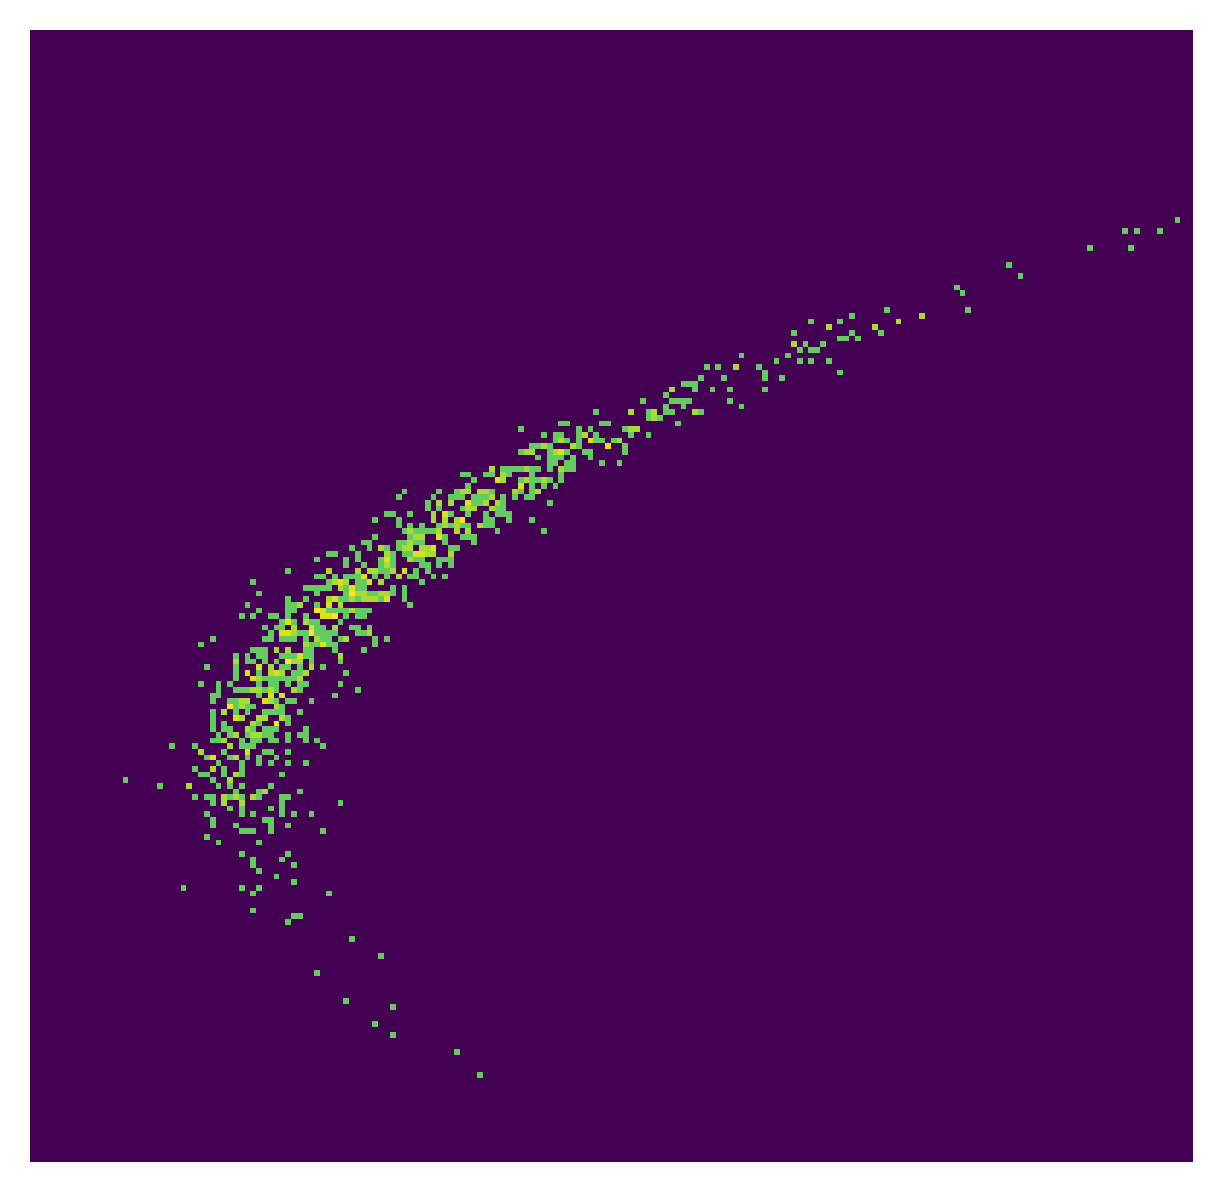

In [87]:
samples_plot_true = np.array(q_true.view(-1, n_dim))
plot_hist(samples_plot_true, title = '', gamma = 0.2,save_path = 'histogram_true_funnel1.pdf')

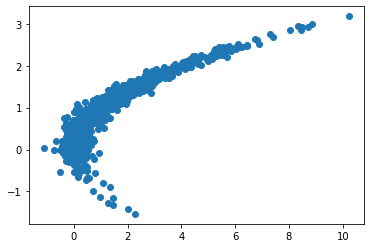

In [88]:
plt.scatter(samples_plot_true[:,0], samples_plot_true[:,1])

## Training with flows

In [89]:
batch_size_sample = 500
loss = "mix_kl" 
flow = RNVP(num_flows = 4, dim = n_dim )

In [90]:
params = flow.parameters()
optimizer = get_optimizer(params, optimizer = "Adam", lr = 1e-3, weight_decay=1e-3)

In [91]:
z_0 = proposal.sample((batch_size_sample,))
z_0.shape

torch.Size([500, 50])

In [92]:
z_1, _ = flow(z_0)

In [94]:
loss_function = get_loss(loss)

In [95]:
N_optim = 1000
alpha = 0.
n_steps = 1
N = 5
grad_step = 2e-3
noise_scale = (2*grad_step)**.5
losses = []

z_ = z_0.clone()
for i in tqdm(range(N_optim)):
    zl, accept, grad_step = ex2_mcmc_mala(z_, true_target,  proposal, n_steps, N, grad_step, (2*grad_step)**.5, 
                        mala_steps = 100, corr_coef=.9, bernoulli_prob_corr=0.3, flow=flow,adapt_stepsize=True)
    #zl = adaptive_sir_correlated_dynamics(z_, true_target, proposal, n_steps, N, alpha, flow)
    #print(zl)
    z_ = zl[-1]
    #print(z_.shape)
    loss, grad_loss = loss_function(true_target, proposal, flow, z_, alpha = i/(2*N_optim)+.5)
    losses.append(loss.detach().numpy())
    verbose = 50
    if i%verbose == 0:
        print("loss = ", np.mean(losses[-verbose:]))
        print("grad_step = ", grad_step)
        print("mean acceptance = ", accept.mean().numpy()*100,"%")

    (grad_loss).backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 1/1000 [00:00<07:33,  2.20it/s]

loss =  -784833.4
grad_step =  1.5208979995746947e-05
mean acceptance =  13.847996294498444 %


  5%|▌         | 51/1000 [00:22<07:03,  2.24it/s]

loss =  -511.03125
grad_step =  0.0265498973539663
mean acceptance =  95.69398760795593 %


 10%|█         | 101/1000 [00:44<06:48,  2.20it/s]

loss =  -1359.1733
grad_step =  0.0265498973539663
mean acceptance =  97.54199981689453 %


 15%|█▌        | 151/1000 [01:06<06:08,  2.30it/s]

loss =  272.59253
grad_step =  0.03388514447913473
mean acceptance =  97.58999347686768 %


 20%|██        | 201/1000 [01:27<05:43,  2.33it/s]

loss =  -89.49229
grad_step =  0.03388514447913473
mean acceptance =  97.20001816749573 %


 25%|██▌       | 251/1000 [01:48<05:19,  2.34it/s]

loss =  -208.52283
grad_step =  0.03388514447913473
mean acceptance =  97.4760115146637 %


 30%|███       | 301/1000 [02:10<04:55,  2.36it/s]

loss =  -246.41467
grad_step =  0.03388514447913473
mean acceptance =  97.22799062728882 %


 35%|███▌      | 351/1000 [02:31<04:35,  2.35it/s]

loss =  -287.3601
grad_step =  0.03388514447913473
mean acceptance =  97.51200675964355 %


 40%|████      | 401/1000 [02:52<04:10,  2.39it/s]

loss =  -392.9667
grad_step =  0.03388514447913473
mean acceptance =  97.1340000629425 %


 45%|████▌     | 451/1000 [03:13<03:52,  2.36it/s]

loss =  -424.466
grad_step =  0.03388514447913473
mean acceptance =  96.66401147842407 %


 50%|█████     | 501/1000 [03:35<03:31,  2.36it/s]

loss =  -548.40405
grad_step =  0.03388514447913473
mean acceptance =  96.82402610778809 %


 55%|█████▌    | 551/1000 [03:56<03:06,  2.41it/s]

loss =  -483.15613
grad_step =  0.03388514447913473
mean acceptance =  96.77999019622803 %


 60%|██████    | 601/1000 [04:17<02:46,  2.39it/s]

loss =  -389.25684
grad_step =  0.03388514447913473
mean acceptance =  92.17200875282288 %


 65%|██████▌   | 651/1000 [04:38<02:27,  2.37it/s]

loss =  -14025.651
grad_step =  0.03388514447913473
mean acceptance =  91.92399978637695 %


 70%|███████   | 701/1000 [04:59<02:03,  2.42it/s]

loss =  -110.5753
grad_step =  0.03388514447913473
mean acceptance =  92.29602813720703 %


 75%|███████▌  | 751/1000 [05:20<01:45,  2.35it/s]

loss =  99.624626
grad_step =  0.03388514447913473
mean acceptance =  92.54000186920166 %


 80%|████████  | 801/1000 [05:40<01:21,  2.43it/s]

loss =  73.78991
grad_step =  0.03388514447913473
mean acceptance =  93.09200048446655 %


 85%|████████▌ | 851/1000 [06:01<01:03,  2.35it/s]

loss =  57.07394
grad_step =  0.03388514447913473
mean acceptance =  93.32001805305481 %


 90%|█████████ | 901/1000 [06:22<00:41,  2.37it/s]

loss =  43.52577
grad_step =  0.03388514447913473
mean acceptance =  93.32599639892578 %


 95%|█████████▌| 951/1000 [06:42<00:20,  2.45it/s]

loss =  18.377293
grad_step =  0.03388514447913473
mean acceptance =  93.39401721954346 %


100%|██████████| 1000/1000 [07:02<00:00,  2.37it/s]


In [96]:
print("loss = ", loss.detach().numpy())
print("grad_step = ", grad_step)

loss =  4.5696683
grad_step =  0.00025767924226807764


In [97]:
grad_step

0.00025767924226807764

In [98]:
array = []
for s in zl:
    s=s.detach().numpy()
    print(s.shape)
    array.append(s)
np.array(array).shape
samples = np.array(array).reshape(-1, n_dim)


(500, 50)
(500, 50)


In [99]:
samples = np.array(array).reshape(-1, n_dim)
samples.shape

(1000, 50)

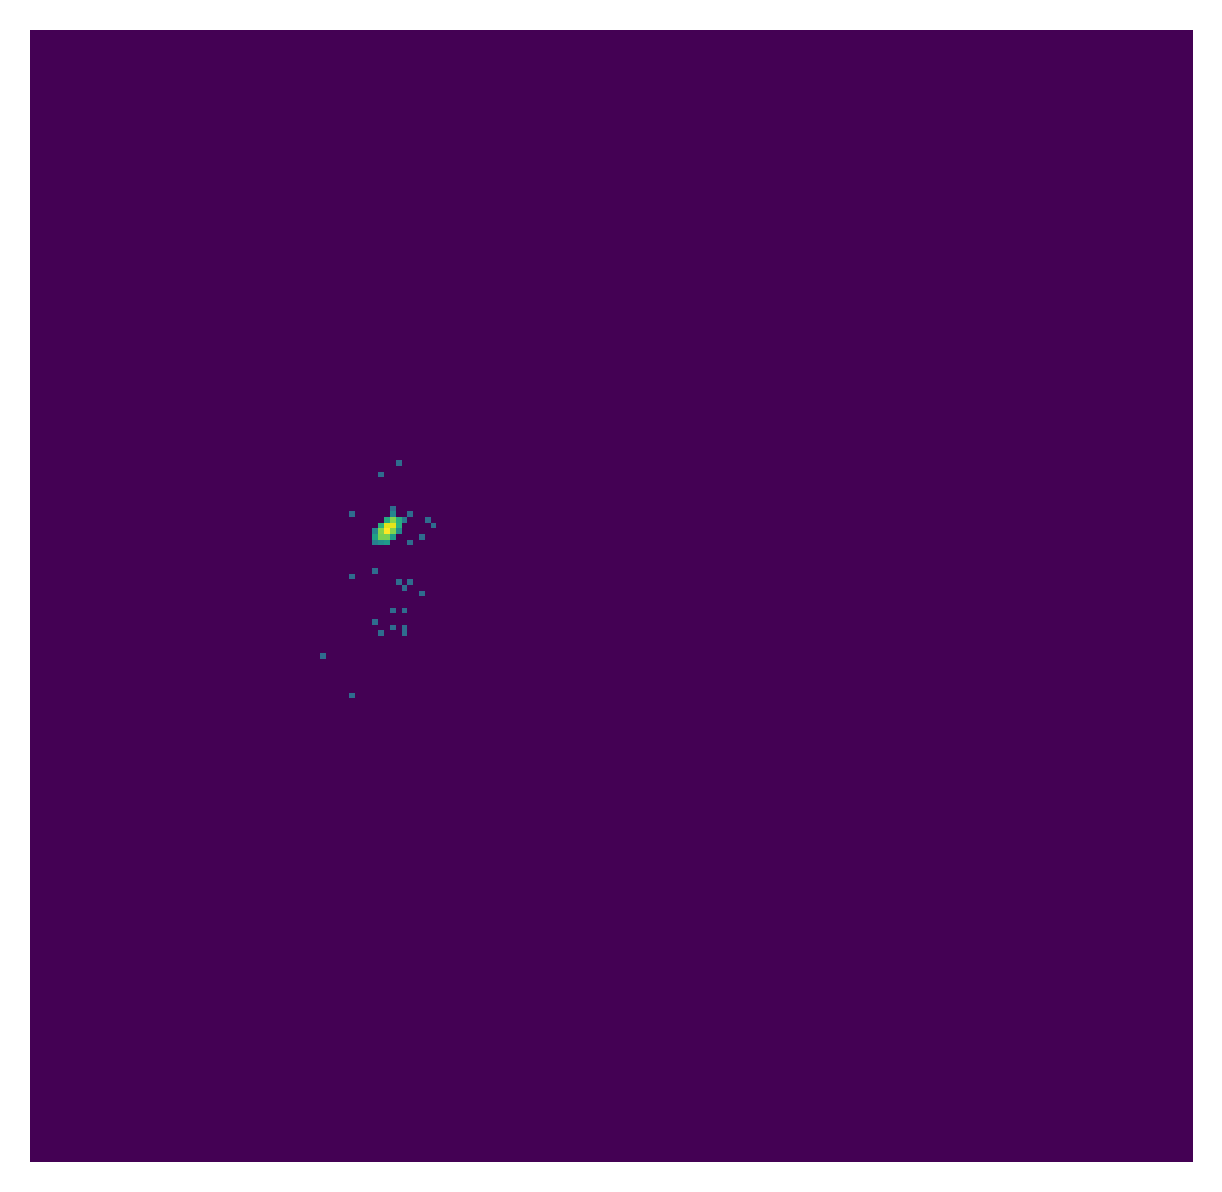

In [100]:
plot_hist(samples, title = '', gamma = 0.2,save_path = 'Ex2MC_wo_flows.pdf')


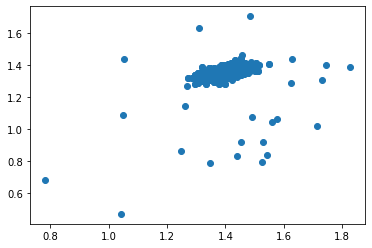

In [101]:
plt.scatter(samples[:,0], samples[:,1])

In [102]:
zl, accept, grad_step = ex2_mcmc_mala(z_, true_target,  proposal, 100, N, grad_step, (2*grad_step)**.5, 
                        mala_steps = 100, corr_coef=.9, bernoulli_prob_corr=0.3, flow=flow,adapt_stepsize=True)
    

In [ ]:
array = []
for s in zl:
    s=s.detach().numpy()
    print(s.shape)
    array.append(s)
np.array(array).shape
samples = np.array(array).reshape(-1, n_dim)


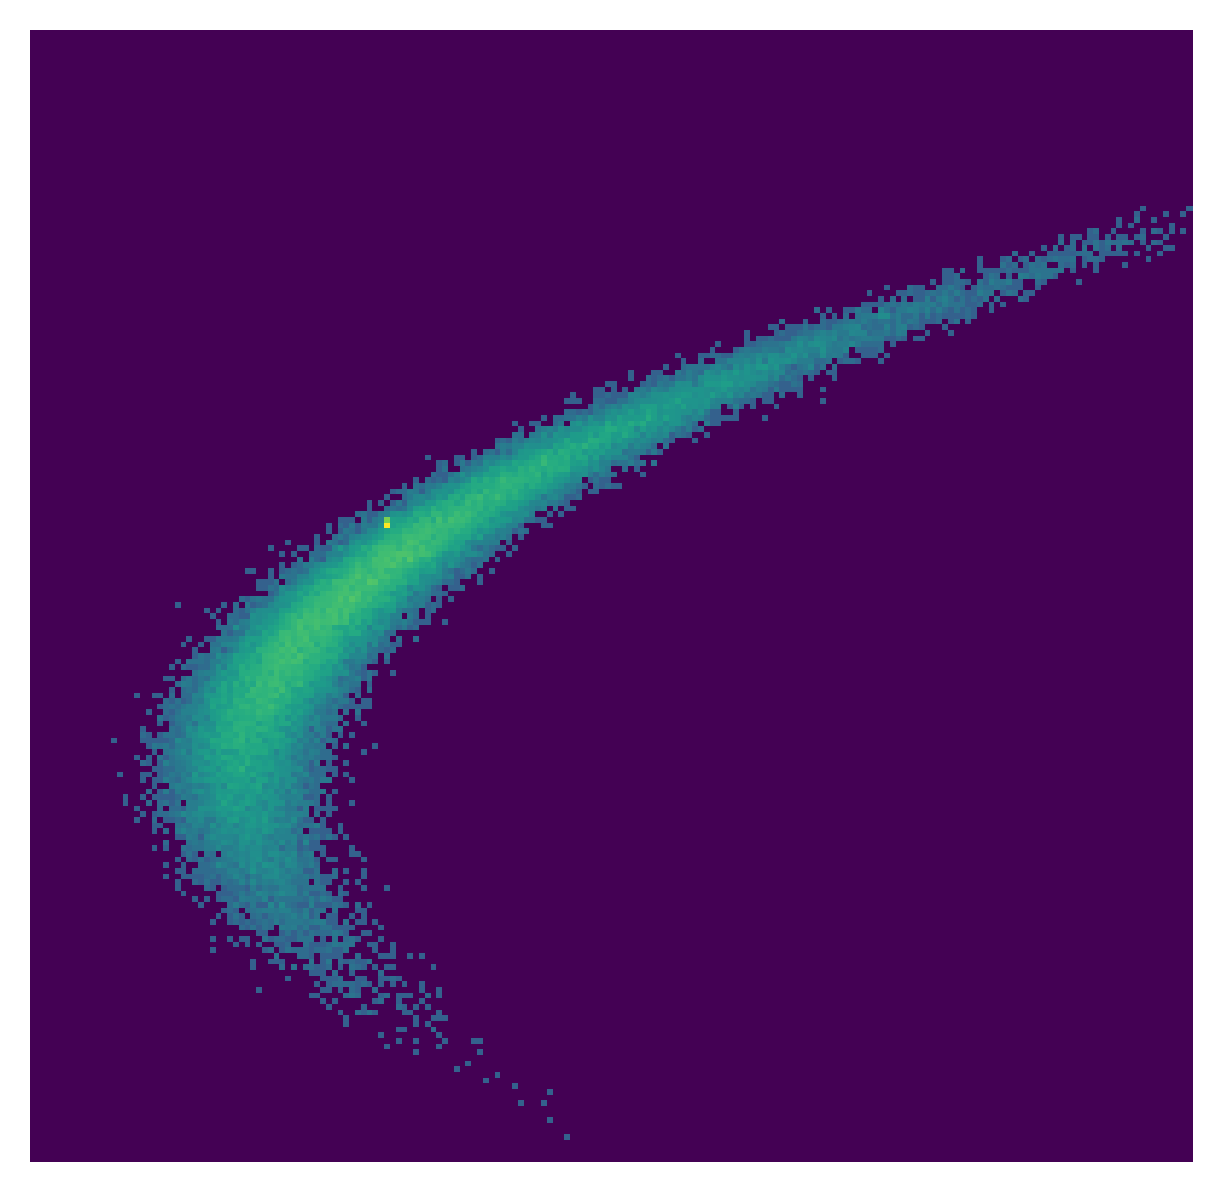

In [104]:
plot_hist(samples, title = '', gamma = 0.2,save_path = 'Ex2MC_wo_flows.pdf')
